In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from numba import njit
import dask.dataframe as dd
from scipy.stats import multinomial, dirichlet 

# Statistiche
## ML con features = Z & A
*classification problem*: Fissato il punto $(Z,A)$ è fissata la predizione --> nessuna interpretazione probabilistica.       
*NN con softmax*: trucco, tanto vale usare p! Anche qui fissato Z ed A ed avendo accesso solo a queste informazioni realisticamente il meglio che la rete potrà fare è dare alle due categorie merge/non merge nel one hot encoding punteggi dati da p e 1-p di cui sotto        
*Generative models*: boh

## ML con features = ...
Così classification/prob. estimation con NN + softmax finale potrebbero dare effettivamente risultati non banali come sopra, ma è un problema diverso, da cui difficilmente districo Z e A dal resto (vista la incomprensibilità intrinseca di un modello di ML finito, arduo da interpretare)

## Bayes
*par. est.*: Z e A sicuramente influenzano il merge/non merge ma non in modo esclusivo; posso modellizzare merge/non merge come una var. random la cui distribuzione è parametrizzata da A e Z (che influenzano l'outcome). Se uso una verosimiglianza binomiale sto nascondendo la mancanza di conoscenza sugli altri parametri in un coin toss; ogni (Z,A) identifica un problema diverso dove la migliore stima di p con un prior uniforme è #merge/tot perché in questo caso ho posterior $\propto$ likelihood --> MAP bayesiano = MLE frequentista. Confrontare questi p è facile.     
*model comp./hyp. t.*: L'approccio di cui sopra non permette di unificare fin da subito (Z,A) diversi né è unico; si potrebbe imparare un modello parametrico/nonparametrico dai dati (con eventualmente hypothesis testing) per una verosimiglianza più realistica (?), ma brancoliamo nel buio           
**ANZI**: *non serve!* Infatti:       
a) non posso credere che per qualcosa di così complesso si riesca a costruire una serie di modelli sulla base di principi fisici       
b) costruire tante possibilità a sentimento non ha senso. Infatti anche se costruisci qualcosa di molto flessibile a quel punto stai solo facendo overfitting dei dati e costruendo qualcosa che non ha una interpretazione semplice (stessi problemi che affliggono le NN, quindi siamo punto e accapo).

## IT 
Forse la più semplice cosa non banale è usare la *mutual information* come matrice di covarianza potenziata per misurare quanto la conoscenza di Z e/o A permetta di determinare il valore della var. random merge/non merge!           
Note prese da sotto:            
1) Tutto sta nel costruire la matrice pmf rappresentante la joint dist., che sommata lungo le righe/colonne ci dà le due marginali; se queste preservano la forma (eventualmente le si constringe mediante reshape/ None o np.newaxis nel posto giusto) possiamo sfruttare il broadcasting per vettorizzare il calcolo della mutual information.                  
2) Ma come si interpreta il risultato? Bits e nats sono quantità astratte...

In [2]:
df1 = pd.read_csv("https://www.dropbox.com/s/md7b7vh157ujyge/df1_mid.csv?dl=1")

In [3]:
from itertools import product 

Z_values, A_values = np.unique(df1.Z), np.unique(df1.A)

In [4]:
ZA = list(product(Z_values, A_values))
print(ZA)

[(0.0002, 0.1), (0.0002, 1.0), (0.0002, 5.0), (0.002, 0.1), (0.002, 1.0), (0.002, 5.0), (0.02, 0.1), (0.02, 1.0), (0.02, 5.0)]


In [5]:
p = np.zeros(len(ZA))
p2 = np.zeros(len(ZA))
df_merge = df1[df1.BWorldtime + df1.Merge_time_midpoint < 14e3]
df_non_merge = df1[~(df1.BWorldtime + df1.Merge_time_midpoint < 14e3)]
# con df_merge andiamo a selezionare unicamente quelle binarie il cui tempo di fusione non supera il tempo di evoluzione dell'univero, Hubble time. In questo caso bisogna utilizzare sia il bwordltime che il merge_time_midpoint che corrispondono a:
# bwordltime=tempo a cui è stata interrotta la simulazione che pertanto parte dai due oggetti del binario separati 
# merge_time_midpoint=tempo di merge rispetto al bworldtime come condizione iniziale nel risolvere il sistema di equazioni differenziali che caratterizzano l'evoluzione del sistema binario

for i, tup in enumerate(ZA) :
    Z, A = tup
    p[i] = len(df_merge[(df_merge.Z == Z) & (df_merge.A == A)])/len(df1)
    p2[i] = len(df_non_merge[(df_non_merge.Z == Z) & (df_non_merge.A == A)])/len(df1)
    print(f"merge prob. for (Z,A) = {tup}: {p[i]}")
    # in questo modo è calcolata la stima frequentista che ci dice quanti mergers sono stati osservati per 
    # ciacun valore di Z e A rispetto al totale misurati sempre con quel particolare Z e A

pmf = p.reshape(len(Z_values), len(A_values))
print("")
print(pmf)

merge prob. for (Z,A) = (0.0002, 0.1): 0.009337100630297761
merge prob. for (Z,A) = (0.0002, 1.0): 0.030454249076287764
merge prob. for (Z,A) = (0.0002, 5.0): 0.06350358617691806
merge prob. for (Z,A) = (0.002, 0.1): 0.006350793305803086
merge prob. for (Z,A) = (0.002, 1.0): 0.030901977830906324
merge prob. for (Z,A) = (0.002, 5.0): 0.03923929580525973
merge prob. for (Z,A) = (0.02, 0.1): 0.002329928276461639
merge prob. for (Z,A) = (0.02, 1.0): 0.001469245816126929
merge prob. for (Z,A) = (0.02, 5.0): 0.0009041512714627255

[[0.0093371  0.03045425 0.06350359]
 [0.00635079 0.03090198 0.0392393 ]
 [0.00232993 0.00146925 0.00090415]]


In [6]:
# # x = Z, y = A --> righe = A, colonne = Z
# X = np.array(ZA)[:,0].reshape((len(A_values), len(Z_values)))
# Y = np.array(ZA)[:,1].reshape((len(A_values), len(Z_values)))
# M = p.reshape((len(A_values), len(Z_values)))
# print(X)
# print(Y)
# print(M)

# è il contrario? In p fissare la riga significa fissare Z ecc.

In [7]:
import seaborn as sns

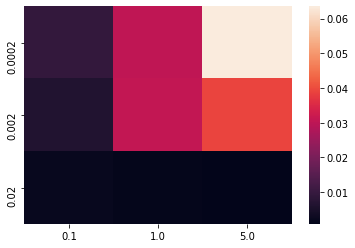

In [8]:
sns.heatmap(p.reshape((len(A_values), len(Z_values))), xticklabels = A_values, yticklabels = Z_values);

## Costruiamo la matrice di confusione che rappresenta la joint probability delle due distribuzioni X e Y

Scegliamo due distribuzioni di probabilità: 
- la prima riguarda il numero di mergers rispetto al totale
- la seconda invece riguarda la distribuzione dei sistemi binari al variare di (Z,A)

La matrice di confusione che andremo a scrivere descrive la joint probability di osservare un certo numero di mergers per un determinato valore della coppia (Z,A).
Cosa rappresenterebbe il risultato della mutual information tra la distribuzione della popolazione di sistemi binari che fanno merge oppure no e la distribuzione delle misure in (Z,a)?

**Prima interpretazione**

Se per ottenere quanti oggetti fanno un merge oppure no ho bisogno di risolvere un sistema di equazioni differenziali contenenti informazioni sulla massa, e caratteristiche geometriche del sistema osservo che non vi compaia direttamente una dipendenza in (Z,a).
Allora è lecita la domanda: se inizialmente il sistema di equazioni differenziali è codificato attraverso l'informazione di cinque valori float, 5*64 bits, sarebbe possibile, aggiungendo informazione su altri due float (Z,a) comprimere il contenuto in bits del sistema di equazioni differenziali? Ovvero in altre parole, se Z e a fossero noti avremmo un vantaggio in termini di bits nell'utilizzare un sistema di equazioni differenziali, sebbene non per forza noto in quanto non si conosce la dipendenza esplicita in Z ed a, per ottenere il medesimo risultato di numero di oggetti binari che fanno un merge oppure no?
L'informazione codificata dalla nuova rappresentazione equivarrebbe al numero iniziale di bits utilizzati ($5 \cdot 64$), meno la mutual information tra le due distribuzioni, più i bits necessari per rappresentare Z e a ($2 \cdot 64$ o anche meno essendo Z un intero positivo e a non ricordo :( )
Se trovassimo che il rapporto tra il contenuto finale in informazione e quello iniziale fosse minore di uno allora avremmo effettivamente dimostrato che una nuova rappresentazione, in questo momento ignota ma potrebbe far nascere sviluppi interessanti della teoria che sta dietro il merge di oggetti binari, del sistema di equazioni differenziali condurrebbe ad un impiego minore di risorse al fine di ottenere lo specifico risultato di  "quanti sistemi binari si fondono e quanti no"

**Seconda interpretazione**

Utilizziamo come valore di riferimento, per dare un significato alla mutual information $I(P(X),P(Y))$, l'entropia di Shannon della distribuzione di probabilità marginale $P(X)$.
Sia $P(X)$ la probabilità, determinata da una stima frequentista, che un sistema binario effettui un merge. Con $S(X)$ intendiamo l'entropia a disposizione a proposito di quanti sistemi binari effettuino un merge. 
Calcolando la mutual information $I(P(X),P(Y))$ scopriamo di quanto migliora la nostra conoscenza del problema se oltre al numero di mergers conosciamo quanti di loro sono caratterizzati da una determinata coppia di valori Z,A.
Dunque $S(X') = S(X) - I$ con I compreso fra 0 ed $S(X)$ (ovviamente I non lo può superare per il discorso delle intersezioni fra insiemi) allora questo significa che $S(X')/S(X) = 1 - I/S(X)$, che è un numero compreso fra 0 e 1 in maniera analoga al coefficiente di correlazione lineare dove 0 = distribuzioni indipendenti, e 1 = così dipendenti da essere legati in modo deterministico. In conclusione il rapporto tra l'entropia di $X$ dopo e prima aver introdotto nel problema i valori di Z,A rappresenta una misura di correlazione vero e propria.

In [9]:
# creo innanzitutto una matrice 9x2 oppure 2x9 contenente le informazioni di merge e dei parametri Z,A

first_row = p
second_row = 1 - p  

confusion = np.array((first_row,second_row))

def kl(x,y):
    s = 0
    for i in range(len(x)):
        s += x[i] * np.log(x[i]/y[i])
    return s 

print(kl(confusion[1],confusion[0]))
print(kl(confusion[0],confusion[1]))

41.48723517875449
-0.6139217596194698


**KL con distribuzioni di probabilità sbagliate $P(X), Q(X)$**

Per come è stata costruita la matrice di confusione sono state rappresentate le distribuzioni di probabilità, una reciproca dell'altra, che un sistema binario con un particolare valore di Z,A (random variable) abbia fatto un merge oppure no. La mutual information mi fornirebbe dunque quanta informazione guadagno rispetto al numero di binari che fanno merge se conoscessi quanti oggetti non fanno un merge ---> tale risultato è inutile perchè le due distribuzioni si possono facilmente ottenere l'una dall'altra come 

$$ P(X) = 1-Q(X) \ \ \ \forall \ X \in \Omega $$

Dove $\Omega$ è il sample space, cioè i valori che possono assumere le coppie Z,A

**Non è questa la matrice di confusione che bisogna scrivere in quanto le due distribuzioni sono quella dei mergers e quella dei Z,A** 
Pertanto la random variable $X$ sono i valori che possono assumere Z,A
$$X \in [(0.0002, 0.1), (0.0002, 1.0), (0.0002, 5.0), (0.002, 0.1), (0.002, 1.0), (0.002, 5.0), (0.02, 0.1), (0.02, 1.0), (0.02, 5.0)]$$
Mentre le due distribuzioni di probabilità ci dicono 

- la prima $P(X)$ quanti sistemi con un certo valore della coppia Z,A hanno fatto un merge 
- la seconda invece misura, tramite una stima frequentista, quale sia la probabilità di osservare rispetto a tutte le misure (indipendentemente da merge o meno) quanti sistemi binari assumono un determinato Z,A 

In [10]:
# PROVA

len(df1[(df1.Z == ZA[0][0]) & (df1.A == ZA[0][1])])/len(df1)
# display(df1.Z == ZA[0][0])
# display(df1.A == ZA[0][1]) 

0.09381004129537057

In [11]:
# first_row continua ad essere in effetti la prima riga della nostra matrice di confusione 
# second_row invece deve contenere per ciascuna coppia quanti oggetti ci sono rispetto al totale delle misure 

p1 = np.zeros(len(ZA))
for i, tup in enumerate(ZA) :
    Z, A = tup
    p1[i] = len(df1[(df1.Z == Z) & (df1.A == A)])/len(df1)
    
first_row1 = first_row
second_row1 = p1 

In [12]:
confusion1 = np.array((first_row1,second_row1))
print(kl(confusion1[0],confusion1[1]))
print(kl(confusion1[1],confusion1[0]))

-0.28121489049558435
1.944340544016608


In [13]:
np.sum(confusion1,axis=1).sum() 
# non è normalizzata infatti la marginale dunque non può essere una distribuzione di probabilità 

1.184490328189524

## Dovrebbero essere uguali ma a quanto pare la prima interpetazione di divergenza conduce ad una distanza, in un caso, negativa tale da rendere impossibile usarla :()

**La quantità che ho trovato non è una mutual information utile a confrontare la joint probability $P(X,Y)$ e il prodotto delle marginali $P(X) \cdot P(Y)$**

Capiamo innanzitutto quali sono le due distribuzioni che inizialmente ci hanno spinto a voler investigare sulla loro correlazione:

- $P(X,Y)$ è la joint probability di osservare un sistema binario fare merge o meno, $X=0,1$, e che un sistema binario abbia un determinato valore di Z,A, $Y \in [(0.0002, 0.1), (0.0002, 1.0), (0.0002, 5.0), (0.002, 0.1), (0.002, 1.0), (0.002, 5.0), (0.02, 0.1), (0.02, 1.0), (0.02, 5.0)]$

- $P(X)$ e $P(Y)$ sono separatamente le due distribuzioni di probabilità marginali e il loro prodotto restituisce la joint unicamente nel caso in cui esse siano indipendenti. 

Pertanto il risultato che desideriamo ottenere è una quantità compresa tra zero, escluso, per capire se effettivamente le due siano correlate o meno

In [14]:
# confusion è la joint probability mentre sommando su righe e colonne troviamo le probabilità marginali 
# per visualizzarla meglio creo un dataframe

second_row2 = p2
confusion2 = np.array((first_row,second_row2))
jointp = pd.DataFrame(data=confusion2,
                    index=[1,0],
                    columns=ZA)
jointp

,"(0.0002, 0.1)","(0.0002, 1.0)","(0.0002, 5.0)","(0.002, 0.1)","(0.002, 1.0)","(0.002, 5.0)","(0.02, 0.1)","(0.02, 1.0)","(0.02, 5.0)"
1,0.009337,0.030454,0.063504,0.006351,0.030902,0.039239,0.002330,0.001469,0.000904
0,0.084473,0.118583,0.167303,0.080613,0.090472,0.116566,0.053249,0.052267,0.051984


In [15]:
if (jointp.apply(sum,axis=1).sum(),jointp.apply(sum).sum())==(1,1) : 
    print("Le due distribuzioni di probabilità marginali P(X) e P(Y) sono normalizzate")

Le due distribuzioni di probabilità marginali P(X) e P(Y) sono normalizzate


In [16]:
px = np.array(jointp.apply(sum,axis=1))
py = np.array(jointp.apply(sum))
prodp = px[:,None]*py
jointp_array = np.array(jointp)
# in modo da avere anche qui una matrice 9x2 con le righe che corrispondono alla probabilità di X merge o 
# non merge 

def mutual_info(px,py):
    return(np.sum(px*(np.log2(px/py))))

def entropy(px):
    return(-np.sum(px*np.log2(px)))

In [17]:
# prova per vedere se il prodotto tra matrici con np.dot è uguale ad usare il newaxis e il prodotto 
# element wise  
px[:,None].dot(py[None,:]) == px[:,None]*py

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [18]:
xy = mutual_info(jointp_array,prodp)
xy

0.05190732771384882

In [19]:
x = entropy(px)
x

0.6898022997106766

In [20]:
# CORRELAZIONE 
def correlation(joint,pr,px):  
    return 1 - mutual_info(joint,pr)/entropy(px)

correlation(jointp_array,prodp,px)

0.924750428150761

## Dirichlet process 

Consideriamo una dsitribuzione di probabilità multinomiale tale che
$x_i$ sono le N random variable che possono assumere valori in $(0,1)$. Ricordiamo che 
$$ \sum_{i}^k p_i = 1 $$

dove $p_i$ è la probabilità associata all'outcome $x_i = 1$ di ciascuna delle $k$ random variables.

Nel nostro caso il numero totale di trials è pari al numero di eventi osservati indipendentemente dal merge mentre il numero di random variables $k$ è pari a ```len(jointp_array). 

Pertanto ne nostro esperimento per ciascun "lancio" il dado ha ``len(jointp_array)`` possibili facce con cui uscire.
<br> In particolare vogliamo mettere in atto un processo di inferenza sulle probabilità $p_i$ dei $k$ bins che possono occupare le random variables $x_i$ nell'esperimento. 


In [21]:
# costruisco un array contenente il numero di conteggi per ciascuno dei bin 
ptry1 = np.zeros(len(ZA), dtype = "u8")
ptry2 = np.zeros(len(ZA), dtype = "u8")

for i, tup in enumerate(ZA) :
    Z, A = tup
    ptry1[i] = len(df_merge[(df_merge.Z == Z) & (df_merge.A == A)])
    ptry2[i] = len(df_non_merge[(df_non_merge.Z == Z) & (df_non_merge.A == A)])

In [22]:
print("Il numero di trials della likelihood multinomiale è", len(df1))
ptry = np.vstack((ptry1,ptry2)).flatten()

Il numero di trials della likelihood multinomiale è 230050


In [60]:
# passo = np.linspace(0.1,1, num=100)
# questo vettore mi serve per costruire per ogni parametro "p_i" il proprio posterior  
# l = np.array([passo for i in range(2*len(ZA))])

In [24]:
# dirich = np.zeros((2*len(ZA), len(passo)))
# dirich dovrebbe contenere tante righe quanti sono il numero di parametri su cui stiamo facendo inferenza 
# e cioè il numero degli slot della joint probability, e tante colonne quanti sono gli step in cui vogliamo 
# discretizzare ciascun posterior 

In [89]:
ptry

array([ 2148,  7006, 14609,  1461,  7109,  9027,   536,   338,   208,
       19433, 27280, 38488, 18545, 20813, 26816, 12250, 12024, 11959],
      dtype=uint64)

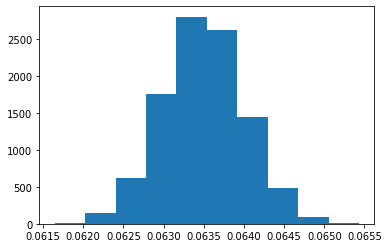

In [83]:
# plt.hist(np.random.dirichlet(ptry + 1,size=10000)[:,2]);
ptrynew = np.zeros(shape = ptry.shape)
for i in range(len(ptry)):
    ptrynew[i] = np.random.dirichlet(ptry,size=len(passo))[:,i].max()

In [87]:
ptrynew.reshape(jointp_array.shape)

array([[0.01012416, 0.03157947, 0.06468254, 0.00692025, 0.03189735,
        0.04027696, 0.00268481, 0.00177239, 0.00103438],
       [0.08570283, 0.12032429, 0.16926581, 0.08217199, 0.09156804,
        0.11854661, 0.05446888, 0.0532804 , 0.05309556]])

In [88]:
jointp_array

array([[0.0093371 , 0.03045425, 0.06350359, 0.00635079, 0.03090198,
        0.0392393 , 0.00232993, 0.00146925, 0.00090415],
       [0.08447294, 0.11858292, 0.16730276, 0.08061291, 0.09047164,
        0.11656596, 0.05324929, 0.0522669 , 0.05198435]])